In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('drive/MyDrive/train_binary.csv')
df_val = pd.read_csv('drive/MyDrive/val_binary.csv')
df_test = pd.read_csv('drive/MyDrive/test_binary.csv')

In [3]:
! pip install lda

In [4]:
! pip install pymorphy2

In [5]:
from nltk.stem import WordNetLemmatizer
import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize, wordpunct_tokenize
import lda
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def get_text(model_text):
    stemmer = WordNetLemmatizer()
    text = []
    for sentence in model_text.split():
        words = word_tokenize(sentence)
        words = ' '.join(words)
        words = words.lower()
        for p in string.punctuation:
          if p in words:
            # банальная замена символа в строке
            words = words.replace(p, '')
        words = re.sub(r'[^\w\s]+|[\d]+', r'',words)
        text.append(''.join(words))
    return text

In [ ]:
def get_pos(list_of_text):
  all_poses = []
  for el in list_of_text:
    for k in el.split():
      all_poses.append(morph.parse(k)[0].tag.POS)
  return all_poses

In [ ]:
df_train['poses'] = df_train['Text'].apply(lambda x: get_pos(get_text(x)))

KeyboardInterrupt: ignored

In [ ]:
df_val['poses'] = df_val['Text'].apply(lambda x: get_pos(get_text(x)))

In [ ]:
df_test['poses'] = df_test['Text'].apply(lambda x: get_pos(get_text(x)))

In [ ]:
df_train

In [ ]:
df_train.columns = ['id', 'input', 'target','poses']
df_train = df_train[['input', 'target','poses']]
df_train['target'].replace({'H': 1, 'M': 0}, inplace=True)
df_train.head()

In [ ]:
df_val.columns = ['input', 'target', 'poses']
df_val = df_val[['input', 'target', 'poses']]
df_val['target'].replace({'H': 1, 'M': 0}, inplace=True)


In [ ]:
df_test.columns = ['id', 'input','poses']
df_test = df_test[['input','poses']]

In [ ]:
df_train['len_tokens'] = df_train['poses'].apply(lambda x: len(x))
df_val['len_tokens'] = df_val['poses'].apply(lambda x: len(x))
df_test['len_tokens'] = df_test['poses'].apply(lambda x: len(x))

In [ ]:
text = df_train.input[0]

In [ ]:
def avg_token_len(text):
  text = text.lower()
  for p in string.punctuation:
      if p in text:
        # банальная замена символа в строке
        words = text.replace(p, '')
        words = re.sub(r'[^\w\s]+|[\d]+', r'',words)
      else:
        words = re.sub(r'[^\w\s]+|[\d]+', r'',text)
        
  
  words = words.split()

  length = 0
  clean_words = []
  for el in words:
    if el not in stopwords.words("russian"):
      clean_words.append(el)
      length += len(el)


  if len(clean_words) > 0:
    result = length / len(clean_words)
  else:
    result = 0


  return round(result)

In [ ]:
def unknown_tag(list_of_tags):
  k = 0
  for el in list_of_tags:
    if el == None:
      k += 1
  return k

In [ ]:
df_train['avg_len_token'] = df_train['input'].apply(lambda x: avg_token_len(x))
df_val['avg_len_token'] = df_val['input'].apply(lambda x: avg_token_len(x))
df_test['avg_len_token'] = df_test['input'].apply(lambda x: avg_token_len(x))

In [ ]:
df_train['unknown_tag'] = df_train['poses'].apply(lambda x: unknown_tag(x))
df_val['unknown_tag'] = df_val['poses'].apply(lambda x: unknown_tag(x))
df_test['unknown_tag'] = df_test['poses'].apply(lambda x: unknown_tag(x))

In [ ]:
sns.countplot(df_train['target'])
plt.title('target distribution in df')

In [ ]:
df_train['target'].value_counts()

In [ ]:
def stroka(sample):
  new_list = []
  for k in sample:
    if k == None:
      new_list.append('NONE')
    else:
      new_list.append(k)
  return ' '.join(new_list)

In [ ]:
df_train['poses'] = df_train['poses'].apply(lambda x: stroka(x))
df_val['poses'] = df_val['poses'].apply(lambda x: stroka(x))
df_test['poses'] = df_test['poses'].apply(lambda x: stroka(x))

In [ ]:
df_train

# Подготовка датасета

In [ ]:
from sklearn.model_selection import train_test_split

Оставляем 60% данных, сохраняем баланс данных (стратифицированный сплин по тагретной переменной)

In [ ]:
new_df_train, _ = train_test_split(df_train, test_size=0.4, random_state=10, shuffle=True, stratify=df_train['target'])

In [ ]:
new_df_train['target'].value_counts()

1    38721
0    38718
Name: target, dtype: int64

In [ ]:
new_df_val, _ = train_test_split(df_val, test_size=0.4, random_state=10, shuffle=True, stratify=df_val['target'])

In [ ]:
df_val['target'].value_counts()

1    10756
0    10755
Name: target, dtype: int64

In [ ]:
new_df_val['target'].value_counts()

1    6453
0    6453
Name: target, dtype: int64

In [ ]:
new_df_train.to_csv('/content/new_df_train.csv', encoding='utf-8')
new_df_val.to_csv('/content/new_df_val.csv', encoding='utf-8')

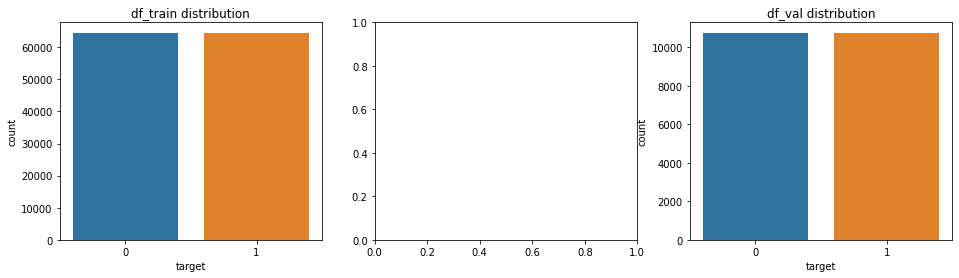

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(df_train['target'], ax = ax1)
ax1.set_title('df_train distribution')

# sns.countplot(df_test['target'], ax = ax2)
# ax2.set_title('df_test distribution')

sns.countplot(df_val['target'], ax = ax3)
ax3.set_title('df_val distribution')

fig.show()

In [6]:
import pandas as pd
import numpy as np

from collections import Counter
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import statistics
import seaborn as sn
import matplotlib.pyplot  as plt
from sklearn.metrics import classification_report, confusion_matrix

from time import time


import joblib
import json
import warnings
warnings.filterwarnings('ignore')

In [7]:
new_df_train = pd.read_csv('drive/MyDrive/new_df_train.csv')

In [8]:
new_df_val = pd.read_csv('drive/MyDrive/new_df_val.csv')

In [9]:
new_df_train['poses'] = new_df_train['poses'].apply(lambda x: x.replace(',','').replace("'",'').replace('[','').replace(']',''))
new_df_val['poses'] = new_df_val['poses'].apply(lambda x: x.replace(',','').replace("'",'').replace('[','').replace(']',''))

In [10]:
new_df_train = new_df_train.drop(columns = ['avg_len_token'],axis = 1)

In [11]:
new_df_val = new_df_val.drop(columns = ['avg_len_token'],axis = 1)

In [12]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

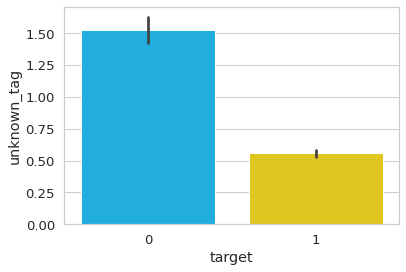

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


x = new_df_train.target
y = new_df_train.unknown_tag

sns.barplot(x=x, y=y);

In [14]:
new_df_train = new_df_train.drop(columns = ['Unnamed: 0'],axis = 1)

In [15]:
new_df_val = new_df_val.drop(columns = ['Unnamed: 0'],axis = 1)

In [16]:
new_df_train.head()

,input,target,poses,len_tokens,unknown_tag
0,"Третьей наложницей. \n- А я не хочу, чтобы ты ...",0,ADJF NOUN CONJ NPRO PRCL VERB CONJ NPRO NPRO V...,92,0
1,"12 декабря 2008 года Додик заявил, что мусульм...",1,NOUN NOUN NOUN VERB CONJ ADJF NOUN PRED INFN I...,15,0
2,БОЛЕЗНЬ ПРОТЕКАЕТ ТЯЖЕЛЕЕ — Как меняется клини...,1,NOUN VERB COMP CONJ VERB ADJF NOUN NOUN,8,0
3,"Троцкистское правительство было, зиновьевское ...",1,ADJF NOUN VERB ADJF NOUN VERB ADJF NOUN VERB P...,15,0
4,Посему больные специально толкались на рынках ...,1,ADVB ADJF ADVB VERB PREP NOUN CONJ PREP NOUN G...,20,0


In [17]:
russian_stopwords = stopwords.words("russian")

In [18]:

new_df_train["num_unique_words"] = new_df_train["input"].apply(lambda x: len(set(str(x).split())))
new_df_val["num_unique_words"] = new_df_val["input"].apply(lambda x: len(set(str(x).split())))


new_df_train["num_chars"] = new_df_train["input"].apply(lambda x: len(str(x)))
new_df_val["num_chars"] = new_df_val["input"].apply(lambda x: len(str(x)))


new_df_train["num_stopwords"] = new_df_train["input"].apply(lambda x: len([w for w in str(x).lower().split() if w in russian_stopwords]))
new_df_val["num_stopwords"] = new_df_val["input"].apply(lambda x: len([w for w in str(x).lower().split() if w in russian_stopwords]))


new_df_train["num_punctuations"] =new_df_train['input'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
new_df_val["num_punctuations"] =new_df_val['input'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )


new_df_train["num_words_upper"] = new_df_train["input"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
new_df_val["num_words_upper"] = new_df_val["input"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


new_df_train["num_words_title"] = new_df_train["input"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
new_df_val["num_words_title"] = new_df_val["input"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


new_df_train["mean_word_len"] = new_df_train["input"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
new_df_val["mean_word_len"] = new_df_val["input"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [19]:
new_df_train.columns

Index(['input', 'target', 'poses', 'len_tokens', 'unknown_tag',
       'num_unique_words', 'num_chars', 'num_stopwords', 'num_punctuations',
       'num_words_upper', 'num_words_title', 'mean_word_len'],
      dtype='object')

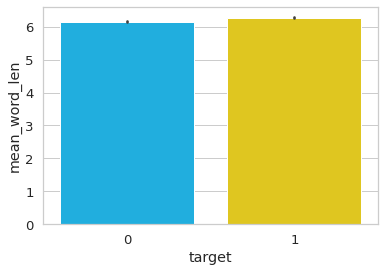

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


x = new_df_train.target
y = new_df_train.mean_word_len

sns.barplot(x=x, y=y);

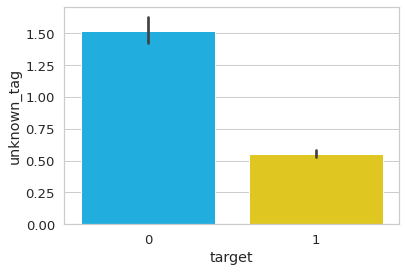

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


x = new_df_train.target
y = new_df_train.unknown_tag

sns.barplot(x=x, y=y);

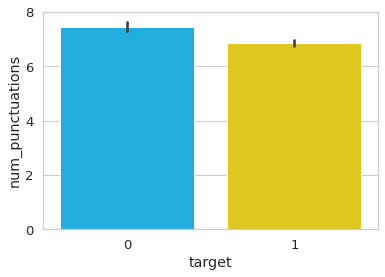

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


x = new_df_train.target
y = new_df_train.num_punctuations

sns.barplot(x=x, y=y);

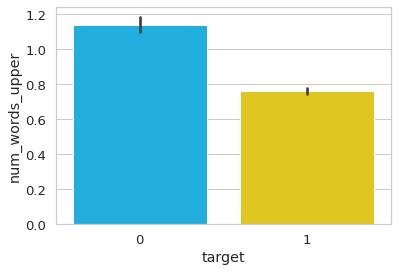

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


x = new_df_train.target
y = new_df_train.num_words_upper

sns.barplot(x=x, y=y);

Посмотрим, влияют ли как-то выведенные нами признаки на таргетную переменную.

In [24]:
cols_to_drop = ['input', 'poses', 'target']
train_X = new_df_train.drop(cols_to_drop, axis=1)
test_X = new_df_val.drop(cols_to_drop, axis=1)

In [25]:
train_X 

,len_tokens,unknown_tag,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,92,0,93,531,40,36,5,10,4.617021
1,15,0,16,128,4,2,0,3,6.588235
2,8,0,9,74,1,1,3,1,7.333333
3,15,0,11,131,2,4,0,1,7.800000
4,20,0,19,123,7,2,0,1,5.200000
...,...,...,...,...,...,...,...,...,...
77434,16,1,13,85,3,4,0,1,4.375000
77435,92,2,80,738,28,14,2,3,7.032609
77436,11,0,11,93,3,1,0,1,7.545455
77437,12,1,13,89,2,8,1,2,5.923077


In [26]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None

In [27]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 2
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [28]:
train_y = new_df_train['target']

In [29]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([new_df_train.shape[0], 2])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:0.692069	test-mlogloss:0.692127
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.658089	test-mlogloss:0.660006
[40]	train-mlogloss:0.643392	test-mlogloss:0.646056
[60]	train-mlogloss:0.632974	test-mlogloss:0.636217
[80]	train-mlogloss:0.622481	test-mlogloss:0.626132
[100]	train-mlogloss:0.616565	test-mlogloss:0.620431
[120]	train-mlogloss:0.61155	test-mlogloss:0.61577
[140]	train-mlogloss:0.606977	test-mlogloss:0.61141
[160]	train-mlogloss:0.602196	test-mlogloss:0.606806
[180]	train-mlogloss:0.598117	test-mlogloss:0.602882
[200]	train-mlogloss:0.595242	test-mlogloss:0.600243
[220]	train-mlogloss:0.592586	test-mlogloss:0.597728
[240]	train-mlogloss:0.59025	test-mlogloss:0.595537
[260]	train-mlogloss:0.588698	test-mlogloss:0.594202
[280]	train-mlogloss:0.586185	test-mlogloss:0.591848
[300]	train-mlogloss:0.584519	test-mlogloss:0.590331
[320]	train

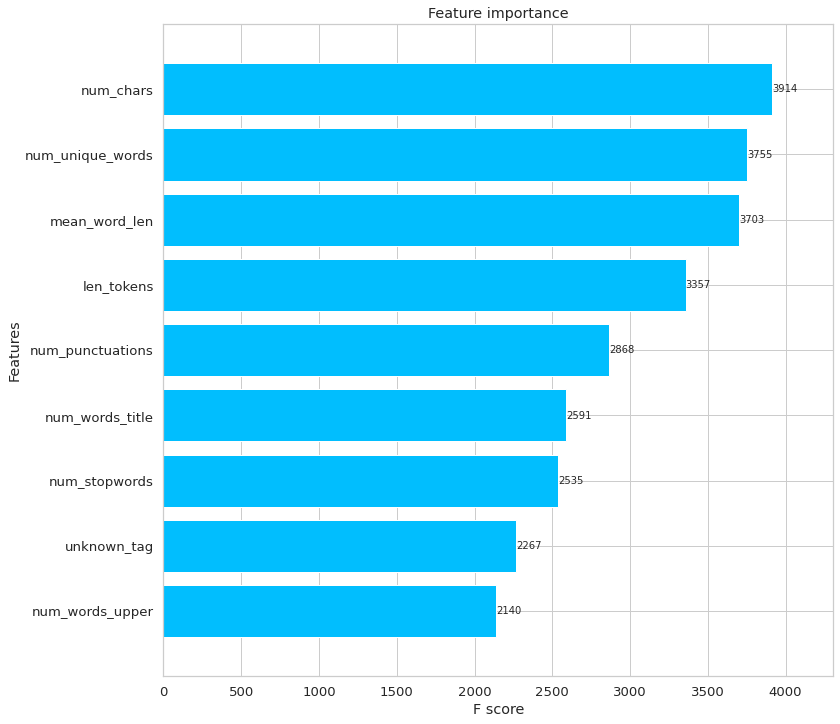

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=10, height=0.8, ax=ax)
plt.show()

In [31]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(new_df_train['input'].values.tolist() + new_df_val['input'].values.tolist())
train_tfidf = tfidf_vec.transform(new_df_train['input'].values.tolist())
test_tfidf = tfidf_vec.transform(new_df_val['input'].values.tolist())

In [32]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [33]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([new_df_train.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.6250140720006392


In [34]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

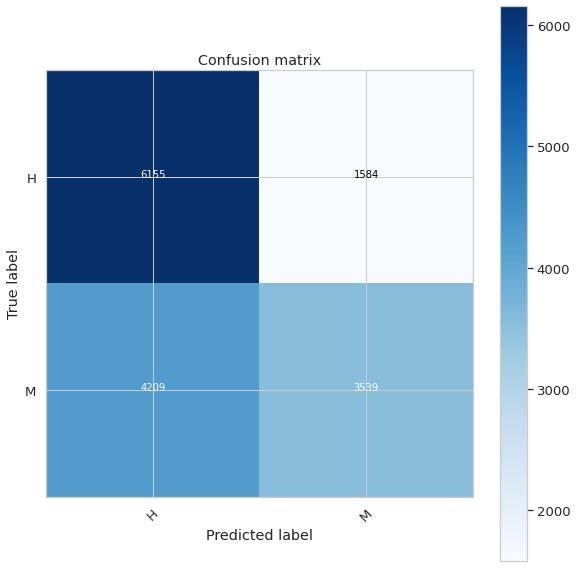

In [35]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['H', 'M'],
                      title='Confusion matrix')
plt.show()

In [36]:

print(classification_report(val_y, np.argmax(pred_val_y,axis=1), target_names=['H', 'M']))

              precision    recall  f1-score   support

           H       0.59      0.80      0.68      7739
           M       0.69      0.46      0.55      7748

    accuracy                           0.63     15487
   macro avg       0.64      0.63      0.61     15487
weighted avg       0.64      0.63      0.61     15487



In [37]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([new_df_train, train_svd], axis=1)
test_df = pd.concat([new_df_val, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [38]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['input'].values.tolist() + test_df['input'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['input'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['input'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_h"] = pred_train[:,0]
train_df["nb_cvec_char_m"] = pred_train[:,1]
test_df["nb_cvec_char_h"] = pred_full_test[:,0]
test_df["nb_cvec_char_m"] = pred_full_test[:,1]

Mean cv score :  0.6177985349761294


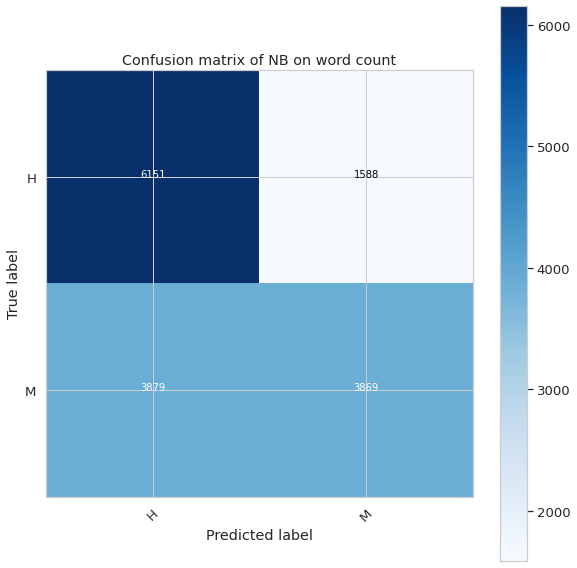

In [39]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['H', 'M'],
                      title='Confusion matrix of NB on word count')
plt.show()

In [40]:
print(classification_report(val_y, np.argmax(pred_val_y,axis=1), target_names=['H', 'M']))

              precision    recall  f1-score   support

           H       0.61      0.79      0.69      7739
           M       0.71      0.50      0.59      7748

    accuracy                           0.65     15487
   macro avg       0.66      0.65      0.64     15487
weighted avg       0.66      0.65      0.64     15487



In [41]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [42]:
cols_to_drop = ['input', 'poses', 'target']
train_X = train_df.drop(cols_to_drop, axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)


[0]	train-mlogloss:0.675283	test-mlogloss:0.675052
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.570457	test-mlogloss:0.571426
[40]	train-mlogloss:0.550783	test-mlogloss:0.553234
[60]	train-mlogloss:0.540547	test-mlogloss:0.544353
[80]	train-mlogloss:0.534099	test-mlogloss:0.539243
[100]	train-mlogloss:0.529572	test-mlogloss:0.535934
[120]	train-mlogloss:0.525353	test-mlogloss:0.533208
[140]	train-mlogloss:0.521788	test-mlogloss:0.530702
[160]	train-mlogloss:0.51891	test-mlogloss:0.529028
[180]	train-mlogloss:0.516367	test-mlogloss:0.527829
[200]	train-mlogloss:0.513766	test-mlogloss:0.526576
[220]	train-mlogloss:0.511414	test-mlogloss:0.525546
[240]	train-mlogloss:0.509197	test-mlogloss:0.524532
[260]	train-mlogloss:0.507055	test-mlogloss:0.52366
[280]	train-mlogloss:0.505008	test-mlogloss:0.523046
[300]	train-mlogloss:0.502973	test-mlogloss:0.522424
[320]	tra

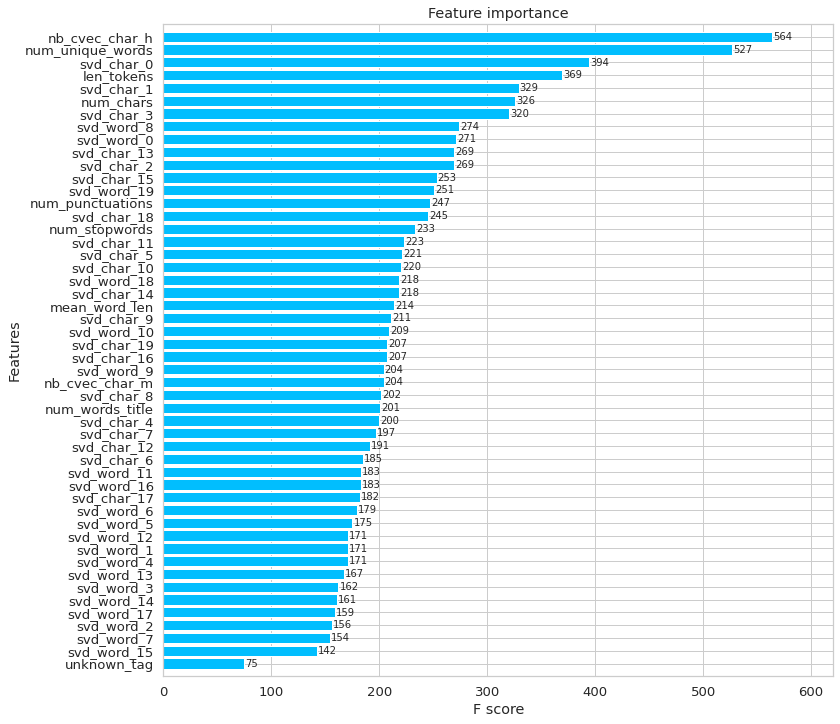

In [43]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

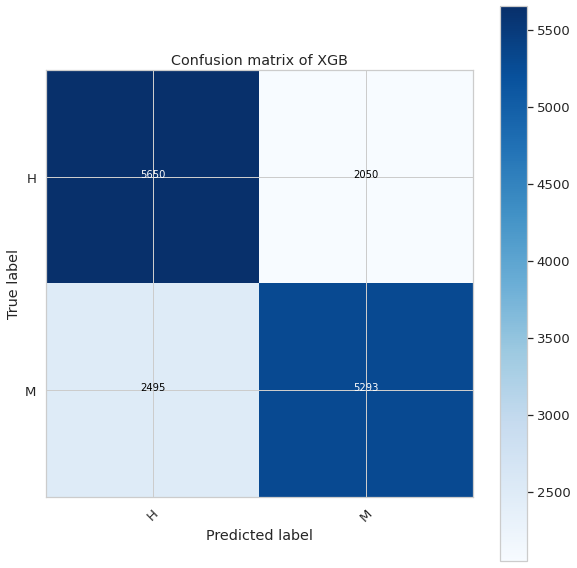

In [44]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['H', 'M'],
                      title='Confusion matrix of XGB')
plt.show()

In [45]:
print('\nClassification Report')
print(classification_report(val_y, np.argmax(pred_val_y,axis=1), target_names=['H','M']))


Classification Report
              precision    recall  f1-score   support

           H       0.69      0.73      0.71      7700
           M       0.72      0.68      0.70      7788

    accuracy                           0.71     15488
   macro avg       0.71      0.71      0.71     15488
weighted avg       0.71      0.71      0.71     15488



In [46]:
def text_cls(CLS_ALGORITHM,X_train,  y_train, X_test, y_test, path_save):
    if CLS_ALGORITHM == 'LogisticRegression':
        nb =  LogisticRegression()
        parameters_nb = {'penalty': ( "l1", "l2"),
                         'C': (1.5, 1, 0.5),
                         'class_weight': ['balanced']}
 
    elif CLS_ALGORITHM == 'MultinomialNB':
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf',MultinomialNB())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
               'clf__alpha': ( 0.01, 0.001)}
    elif CLS_ALGORITHM == 'RandomForestClassifier':   
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', RandomForestClassifier())])
 
 
        parameters_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'clf__class_weight': ("balanced", "balances_subsample")}
    else:
      nb = PassiveAggressiveClassifier()
      parameters_nb = {'max_iter': ( 1000, 2000),
                        'C': (1.5, 1, 0.5),} 

    gs_clf_nb = GridSearchCV(nb, parameters_nb, n_jobs=-1, scoring = "f1_weighted")

    
    gs_clf_nb = gs_clf_nb.fit(X_train, y_train)
    print(gs_clf_nb.best_score_)
    print(gs_clf_nb.best_params_)
    r = gs_clf_nb.best_estimator_
    predicted = r.predict(X_test)
    joblib.dump(r, f'{path_save}_{CLS_ALGORITHM}.pkl')
    return y_test, predicted

In [47]:
def visualize(y_true, y_pred, df, target_column, new_path):
    plt.figure(figsize=(7,5))
    array=confusion_matrix(y_true, y_pred)
    a = [sorted(df[target_column].unique())]
    df_cm = pd.DataFrame(array, index=a, columns=a)
    sn.set(font_scale=1.2)
    sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
    plt.xticks(rotation=60)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Реальный класс')
    plt.savefig(new_path + '_'+ 'image.png')
    plt.show()

In [51]:
vect = TfidfVectorizer(use_idf=True, min_df=50, ngram_range=(1,2))
X_train = vect.fit_transform(new_df_train.input)
y_train = new_df_train.target
X_test = vect.fit_transform(new_df_val.input)
y_test = new_df_val.target

In [52]:
df1 = pd.DataFrame(X_train.toarray())   # //Convert sparse matrix to array
df2 = new_df_train[['len_tokens','unknown_tag', 'num_unique_words', 'num_chars', 'num_stopwords','num_punctuations', 'num_words_upper','num_words_title','mean_word_len']]

newDf_train = pd.concat([df1, df2], axis = 1)

In [53]:
df1 = pd.DataFrame(X_test.toarray())   # //Convert sparse matrix to array
df2 = new_df_val[['len_tokens','unknown_tag', 'num_unique_words', 'num_chars', 'num_stopwords','num_punctuations', 'num_words_upper','num_words_title','mean_word_len']]

newDf_test = pd.concat([df1, df2], axis = 1)

In [ ]:
y_test, predicted = text_cls('PassiveAgressive', newDf_train,  y_train, newDf_test, y_test, './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_df, 'target', './')

0.6683613473075465
{'C': 1.5, 'class_weight': 'balanced', 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      6453
           1       0.68      0.65      0.66      6453

    accuracy                           0.67     12906
   macro avg       0.67      0.67      0.67     12906
weighted avg       0.67      0.67      0.67     12906



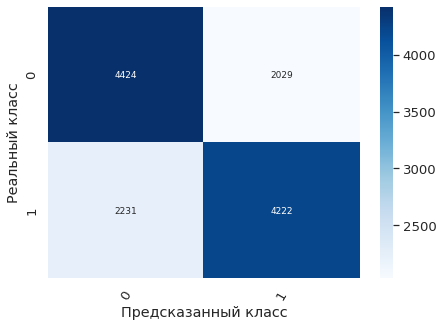

In [50]:
y_test, predicted = text_cls('LogisticRegression', train_X,  train_y, test_X, y_test, './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_df, 'target', './')